Project 4 is created to see whether a different approach in data cleaning works better in the end for the ML algorithm, XGBoost.

NOTE: This project applies the method of a different participant from Kaggle. It was done to compare models created by myself with others. 

Steps: 
1. Download data set
2. Make ID column the name of the rows
3. Fill NaN values using different methods
4. Apply One-Hot Encoding to deal with nominal data
5. Calculate MI scores
6. Create new features
7. Split the data into training and validation sets
8. Apply scaling
9. Apply XGBoost algorithm
10. Apply GridSearch algorithm to tune the hyperparameters

In [1]:
import pandas as pd
train_set = "/Users/serraus/Desktop/house-prices-advanced-regression-techniques/train.csv"
train_set_data = pd.read_csv(train_set)

In [2]:
train_set_data.set_index("Id", inplace=True)

In [ ]:
from function_sheet import category_calculator
for column in train_set_data.columns:
    print("Column:", column)
    category_calculator(train_set_data[column])
    print("-" * 50)

In [4]:
# For some categorical features, NaN means that the feature does not exist in the house.
# So we replace NaN with 'None'.
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
             'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'MasVnrType', 'MSSubClass']
for col in none_cols:
    train_set_data[col] = train_set_data[col].fillna('None')

# For some numerical features, NaN means that the feature does not exist in the house.
# So we replace NaN with 0.
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
             'MasVnrArea']
for col in zero_cols:
    train_set_data[col] = train_set_data[col].fillna(0)

# For the rest of the categorical features, we replace NaN with the most common value (mode).
mode_cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities']
for col in mode_cols:
    train_set_data[col] = train_set_data[col].fillna(train_set_data[col].mode()[0])

# For 'LotFrontage', we fill in missing values by the median LotFrontage of the neighborhood.
train_set_data["LotFrontage"] = train_set_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Check if there are any remaining missing values
train_set_data.isnull().sum().sum()

0

In [9]:
# Perform one-hot encoding
all_data = pd.get_dummies(train_set_data)

all_data.shape

(1460, 306)

In [10]:
from function_sheet import new_features
new_training_data_features = new_features(all_data)
print(new_training_data_features)

      AgeHouse  TotalSF  HasPool
Id                              
1            5     2566        0
2           31     2524        0
3            7     2706        0
4           91     2473        0
5            8     3343        0
...        ...      ...      ...
1456         8     2600        0
1457        32     3615        0
1458        69     3492        0
1459        60     2156        0
1460        43     2512        0

[1460 rows x 3 columns]


In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Columns: 306 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(266), float64(3), int64(37)
memory usage: 846.9 KB


In [13]:
from function_sheet import mi_scores
x = all_data
y = all_data["SalePrice"]
mi = mi_scores(x, y)
mi.head(10)

SalePrice      5.589165
TotalSF        0.677195
OverallQual    0.563705
GrLivArea      0.481239
YearBuilt      0.369837
GarageArea     0.366009
TotalBsmtSF    0.365900
GarageCars     0.353618
AgeHouse       0.345603
1stFlrSF       0.307304
dtype: float64

In [ ]:
X_4 = all_data.drop("SalePrice", axis = 1)
y_4 = all_data.SalePrice
print(X_4, y_4)

In [17]:
#Splitting the data into train/validation sets
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_4, y_4, test_size=0.2, random_state=42) 
#test size means that the data will be splitted as 80% training 20% validation set
#setting random state into a fixed number ensures the same result is obtained when the code is run again


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

In [19]:
#XGBoost 
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

XGBRegressor().fit(x_train, y_train)
model = XGBRegressor(
    n_estimators=300, #number of trees that the model builds, it should be not too high not too low
    learning_rate=0.01, #step-size, used to prevent overfitting, it should be not too lare not too low
    max_depth=5, #maximum depth of a tree
    subsample=0.7, #fraction of samples used for training each tree
    )
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
score = mean_absolute_error(y_valid, y_pred)
score2 = r2_score(y_valid, y_pred)
print("Mean Absolute Error:", score)
print("R^2 score:", score2)

Mean Absolute Error: 18946.37569563356
R^2 score: 0.8586945123441682


In [20]:
from sklearn.model_selection import GridSearchCV

hyperparameter_grid = {
    'n_estimators' : [50, 100, 200, 300],
    'learning_rate' : [0.01, 0.1, 0.2, 0.3],
    'max_depth' : [5,7,9],
    'subsample' : [0.4,0.6,0.8,1.0]
}
model = XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=hyperparameter_grid, cv=5, scoring='neg_mean_absolute_error')
#negative MAE is used because the algorithm is trying to minimize the error
#cv stands for cross validation - which is a technique were data is split into smaller subsets and each of them is tried along the training. 

grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

In [21]:
print(best_params)
print(best_xgb_model)

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.6}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [22]:
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

XGBRegressor().fit(x_train, y_train)
model = XGBRegressor(
    n_estimators=200, #number of trees that the model builds, it should be not too high not too low
    learning_rate=0.1, #step-size, used to prevent overfitting, it should be not too lare not too low
    max_depth=5, #maximum depth of a tree
    subsample=0.6, #fraction of samples used for training each tree
    )
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
score = mean_absolute_error(y_valid, y_pred)
score2 = r2_score(y_valid, y_pred)
print("Mean Absolute Error:", score)
print("R^2 score:", score2)

Mean Absolute Error: 14960.440282534246
R^2 score: 0.9073020073233422


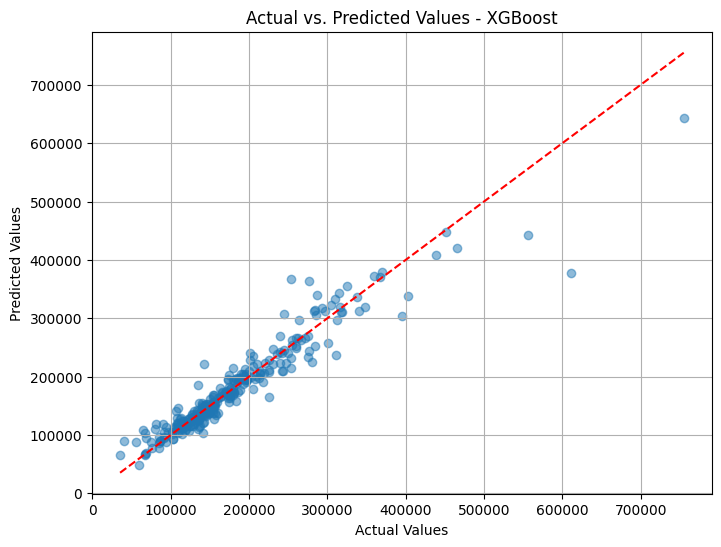

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], linestyle='--', color='r')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values - XGBoost")
plt.grid(True)
plt.show()

There was no significant difference of project 4 with other side projects. The initial project turned out to be the best result with approximately 0.93 R^2 score.